# O que está sendo pedido? 

Utilizando a base fornecida, as equipes devem gerar e avaliar um modelo preditivo que seja capaz de, a partir de um breve texto descritivo sobre uma tecnologia, classificá-la entre os rótulos existentes na base de treinamento.

* Linguagens e Frameworks - 0 - com base na linha 46
* Plataformas - 1 - com base na linha 15
* Ferramentas - 2 - com base na linha 27

### Grupo de trabalho

1. João Freitas,
2. João Kruschewsky,
3. Vinícius Matos, 
4. Vito Magarão 

# Importação da Bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle # muito bom para algoritmos já treinados, manipular o output dos algoritmos de ML 
import seaborn as sns
sns.set_style("whitegrid")
import altair as alt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import ShuffleSplit, cross_validate,GridSearchCV,RandomizedSearchCV,train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,make_scorer,classification_report
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
import numpy as np
import string
import spacy
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB 
import nltk # principal biblioteca do python para processamento de linguagem natural
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

# bibliotecas para esconder os avisos do seaborn
import warnings
warnings.filterwarnings("ignore")
import textwrap 

In [2]:
# comment after running
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Funções

In [3]:
# Função que lista todos os caracteres únicos presentes em todo o dataframe
def get_unique_chars(df): 
    text = ''.join(df['comentario'].astype(str).values.flatten())
    unique_chars = list(set(text))
    return unique_chars


# Limpeza de colunas do dataframe para o primeiro parse 
def cleaning_df (df,column_name):
    df_clean = df.copy()
    exclude_chars = ["’", "—", "–",'™']
    for char in exclude_chars:
        # Essa expressão regular remove todos os caracteres que não estão no alfabeto ou que possuem comprimento menor que 2. Ela também removerá "s" e sinais de pontuação.
        df_clean[column_name] = df_clean[column_name].replace(to_replace=r'[^a-zA-Z]|(\b\w{1}\b)', value=' ', regex=True)
    df_clean[column_name] = df_clean[column_name].replace(regex=r' +', value=' ') # remove quaisquer espaços duplicados ou triplicados que foram gerados como resultado da primeira linha.
    df_clean[column_name] = [content.translate(str.maketrans('','', string.punctuation)) for content in df_clean[column_name]]
    df_clean[column_name] = [content.translate(str.maketrans('','', string.digits)) for content in df_clean[column_name]]
    df_clean[column_name] = df_clean[column_name].str.strip()
    return(df_clean)

In [4]:
# importando o datafram do git
df = pd.read_csv(r'https://raw.githubusercontent.com/MasterExecuson/Data-Science-Analytics/main/Data%20Analytics%20Hands%20on/datasets/base_textos_stack.csv', sep=',', encoding='utf-8')

In [5]:
df_backup = df.copy()

In [6]:
df.set_axis(['comentario','classe'], inplace = True, axis = 1)

O dataframe possui apenas dois atributos relevantes, um referente ao Código de classificação (nosso target) e outro referente ao corpo do texto.

Objetivos:
* Descobrir o que é cada categoria (0-2); 
* Treinar um algoritmo capaz de prever em qual categoria o comentário se enquadra.

In [7]:
df['classe'].unique()

array([1, 0, 2])

A base de dados fornecida já apresenta-se balanceada, considerando a existência do mesmo número de entradas para cada uma das categorias tidas como target. 

Para cada categoria, encontramos 89 entradas e identifcamos que não existem dados sem categoria ou dados nulos.

Existem apenas duas linhas duplicadas com o mesmo target e mesmo comentário (linha 37 e 139), apenas uma delas foi preservada.

Existem duas linhas com target dúbio, ou seja, mesmo texto com duas categorias diferentes. Ambos serão descartados, considerando um erro de coleta e que atrapalharia no treinamento do algoritmo. 

In [8]:
df['classe'].value_counts()

1    89
0    89
2    89
Name: classe, dtype: int64

In [9]:
df.isna().sum()

comentario    0
classe        0
dtype: int64

In [10]:
df.columns

Index(['comentario', 'classe'], dtype='object')

In [11]:
no_comentario_unique = len(df['comentario'].unique())
print(f'O dataset apresenta {df.shape[0]} entradas e {df.shape[1]} atributos.')
print(f'A coluna "comentario", que é a que contem os comentários, possui {no_comentario_unique} entradas únicas.')


O dataset apresenta 267 entradas e 2 atributos.
A coluna "comentario", que é a que contem os comentários, possui 265 entradas únicas.


In [12]:
df.drop_duplicates(inplace = True)

In [13]:
first_duplicate_index = df[df['comentario'].duplicated(keep = 'first')].index[0]
last_duplicate_index = df[df['comentario'].duplicated(keep = 'last')].index[0]
print(f'As linhas de índices {first_duplicate_index} e {last_duplicate_index} apresentam o mesmo comentário, porém classificações divergentes.')

As linhas de índices 262 e 203 apresentam o mesmo comentário, porém classificações divergentes.


In [14]:
print(df.iloc[[first_duplicate_index-1,last_duplicate_index-1]])
print('\n Essas linhas serão descartadas, conforme mencionado anteriormente.')

                                            comentario  classe
262  Docker provides a high-level API to containeri...       2
203  Docker provides a high-level API to containeri...       1

 Essas linhas serão descartadas, conforme mencionado anteriormente.


In [15]:
df.drop([first_duplicate_index,last_duplicate_index], inplace = True)

Verficou-se abaixo que não existe nenhum comentário com número de dígitos menor que 3, feito dessa forma a fim de verificar se existem entradas vazias ou problemáticas nesse sentido. 

In [16]:
for comment in df['comentario']:
    if len(comment) <= 3:
        print(comment)

In [17]:
unique_chars = get_unique_chars(df)
unique_chars.sort(reverse = True)
print(unique_chars)

['™', '’', '—', '–', '~', '|', 'z', 'y', 'x', 'w', 'v', 'u', 't', 's', 'r', 'q', 'p', 'o', 'n', 'm', 'l', 'k', 'j', 'i', 'h', 'g', 'f', 'e', 'd', 'c', 'b', 'a', '`', ']', '[', 'Z', 'Y', 'X', 'W', 'V', 'U', 'T', 'S', 'R', 'Q', 'P', 'O', 'N', 'M', 'L', 'K', 'J', 'I', 'H', 'G', 'F', 'E', 'D', 'C', 'B', 'A', '?', '=', ';', ':', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0', '/', '.', '-', ',', '+', '*', ')', '(', "'", '&', '$', '#', '"', '!', ' ']


Após o output acima, podemos inferir que temos um exemplo razoavelmente bem comportado, onde não existe uma variedade de caracteres acentuados muito expressiva.

O intuito dessa lista é nos ajudar a tomar uma decisão mais educada referente ao tipo de *ENCODING* que utilizaremos. `UTF-8` parece não trazer maiores problemas


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264 entries, 0 to 266
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   comentario  264 non-null    object
 1   classe      264 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 6.2+ KB


In [19]:
df['comentario'] = df['comentario'].astype(str)
df['classe'] = df['classe'].astype('category')

## Verificando a distribuição do comprimento de cada comentário

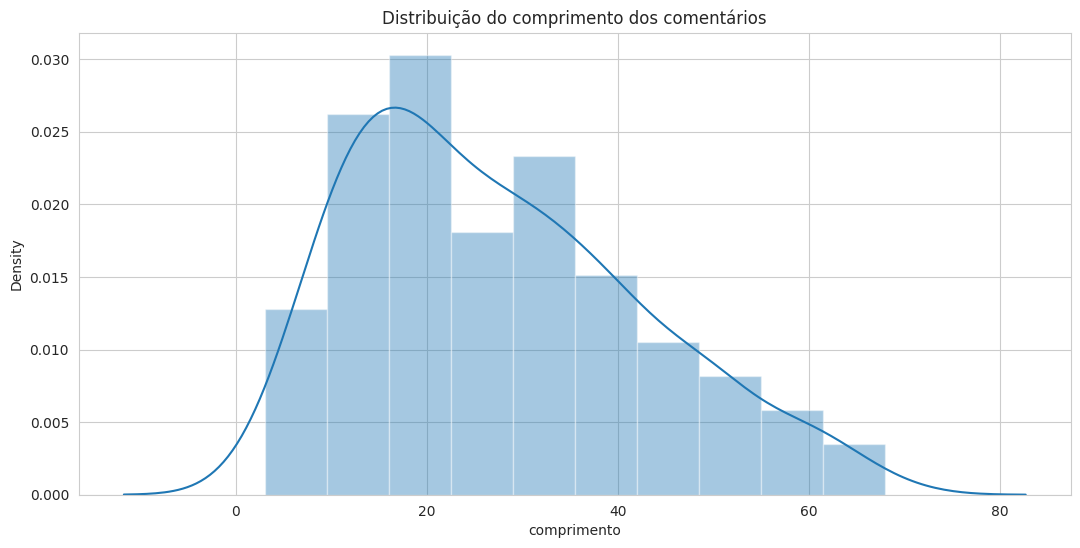

In [20]:
df['comprimento'] =  [len(sentence.split()) for sentence in df['comentario']]
plt.figure(figsize=(12.8,6))
sns.distplot(df['comprimento']).set_title('Distribuição do comprimento dos comentários');

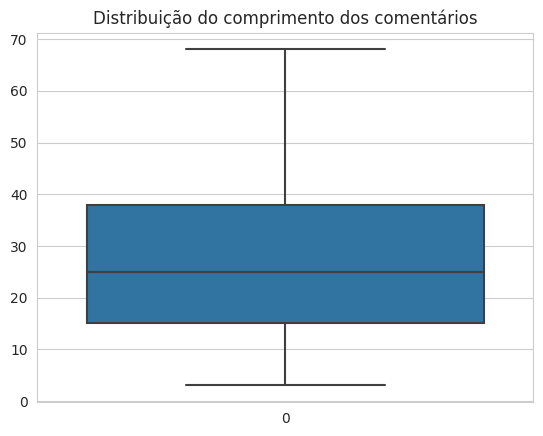

In [21]:
sns.boxplot(df['comprimento']).set_title('Distribuição do comprimento dos comentários');

Desses gráficos podemos analisar que a distribuição do comprimento dos comentários não seguem o padrão normal. Há um uma assimétria para a direita, indicando que a maioria dos comentários possuem até 40 palavras, enquanto os comentários com 40+ palavras são uma minoria. 

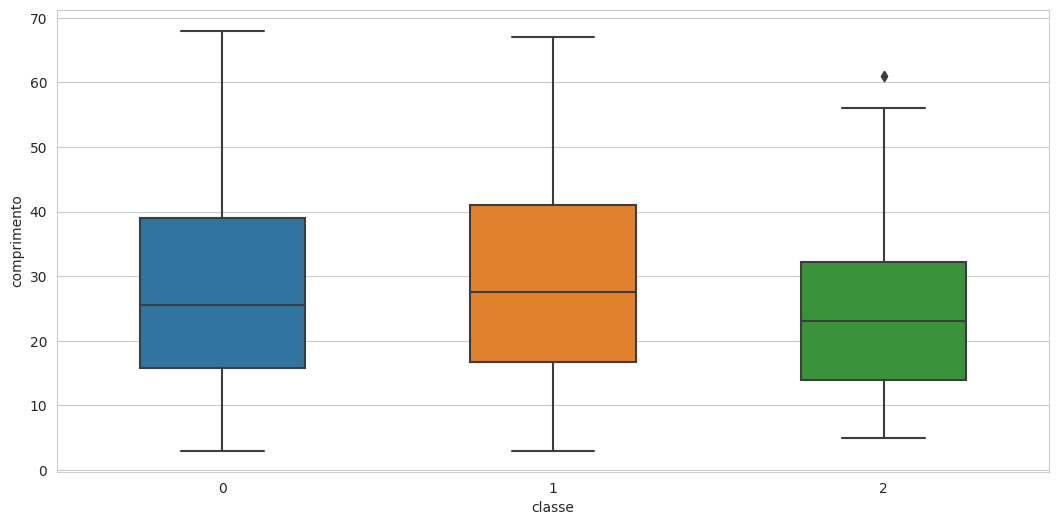

In [22]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=df, x='classe', y='comprimento', width=.5);

Podemos ver que a classe de número 2 possui comprimento um pouco menor que as demais e que todas as classes possuem um leve desvio para a direita. Uma vez que a base de dados é balanceada e os dados são coerentes, não é necessária a exclusão de outliers para uma visualização conclusiva.

In [23]:
df.groupby('classe').describe()

comprimento                                                     
             count       mean        std  min    25%   50%    75%   max
classe                                                                 
0             88.0  28.340909  15.667439  3.0  15.75  25.5  39.00  68.0
1             88.0  29.306818  15.240869  3.0  16.75  27.5  41.00  67.0
2             88.0  24.693182  13.740918  5.0  14.00  23.0  32.25  61.0

Podemos notar que tanto a média e o desvio padrão são praticamente idênticos nas três categorias. Todas estão com 88 comentários e podemos ver que os quartis se comportam levemente diferentes em cada categoria. Máximos e mínimos são quase constantes em todas as categorias presentes.

#Remoção de caracteres especiais e números

É possível identificar que no dataframe temos alguns caracteres que interferem e/ou não contribuem para os resultados finais, removeu-se tudo que era numérico, tudo que era pontuação e adicionalmente sinais gráficos como  [" ’ ", "—", "–",'™']

Verificando se a limpeza foi apropriada, notamos que apenas temos letras na lista de caracteres.

In [24]:
df_clean = cleaning_df(df,'comentario')
unique_chars = get_unique_chars(df_clean)

unique_chars.sort(reverse = True)

In [25]:
# adicionando a nova coluna como Parse_1 no df original
df['parse_1'] = df_clean['comentario']


## Lematização e stematização

In [26]:
# carregando a lista de stopwords em inglês
stop_words = list(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")
wnl = WordNetLemmatizer()
# porter = PorterStemmer()
lancaster=LancasterStemmer()
snowball = SnowballStemmer(language="english")

func_lematizator = lambda x: " ".join([w.lemma_ for w in nlp(x) if w.lemma_ not in stop_words])
func_stemmizator = lambda x: " ".join([lancaster.stem(w) for w in x.lower().split() if w not in stop_words])
func_snowtizator = lambda x: " ".join([snowball.stem(w) for w in x.lower().split() if w not in stop_words])

df['parse_2a'] = df['parse_1'].apply(func_lematizator)
df['parse_2b'] = df['parse_1'].apply(func_stemmizator)
df['parse_2c'] = df['parse_1'].apply(func_snowtizator)

### Evolução após cada iteração

In [27]:
df.loc[15]['comentario']

'Google App Engine is a cloud computing technology for hosting web applications in Google-managed data centers. Google App Engine is a Platform as a Service (PaaS) offering for Java, Python, Go and PHP.'

In [28]:
df.loc[15]['parse_1']

'Google App Engine is cloud computing technology for hosting web applications in Google managed data centers Google App Engine is Platform as Service PaaS offering for Java Python Go and PHP'

In [29]:
df.loc[15]['parse_2a']

'Google App Engine cloud compute technology host web application Google manage datum center Google App Engine platform Service PaaS offering Java Python Go php'

In [30]:
df.loc[15]['parse_2b']

'googl ap engin cloud comput technolog host web apply googl man dat cent googl ap engin platform serv paa off jav python go php'

In [31]:
df.loc[15]['parse_2c']

'googl app engin cloud comput technolog host web applic googl manag data center googl app engin platform servic paa offer java python go php'

In [32]:
#selecionando o modelo que será utilizado

df['parsed'] = df['parse_2b']




In [ ]:
df['parse_2b'].head()

Foi analisado os modelos para todos os modelos, parse_2b e parse_2c obtiveram resultados semelhantes. Parse_2a foi o pior modelo (0.4 de diferença).

parse_a

|	Estimator	|Cross-validation| Scores|	Test Set Scores|
|-----|----|----|----|
0|	Random Forest|	(0.622, 0.628)|	(0.55, 0.556)
1|	SVM|	(0.517, 0.531)	|(0.496, 0.481)
2|	MultinomialNB	|(0.734, 0.737)|	(0.704, 0.704)



parse_b

|	Estimator	|Cross-validation| Scores|	Test Set Scores|
|-----|----|----|----|
0|	Random Forest	|(0.597, 0.62)|	(0.589, 0.593)
1|	SVM	|(0.54, 0.556)|	(0.694, 0.704)
2|	MultinomialNB	|(0.749, 0.759)|	(0.74, 0.741)



parse_c


|	Estimator	|Cross-validation| Scores|	Test Set Scores|
|-----|----|----|----|
0	|Random Forest	|(0.6, 0.616)	|(0.525, 0.519)
1	|SVM	|(0.539, 0.556)	|(0.453, 0.444)
2	|MultinomialNB	|(0.747, 0.75)	|(0.74, 0.741)

# Divisão de conjuntos de treinamento e teste


Como possuímos apenas 264 textos, iremos separar apenas 10% para o conjunto de validação.

In [ ]:
train_df, test_df, train_target, test_target  = train_test_split(df['parsed'], 
                                                    df['classe'], 
                                                    test_size=0.1, 
                                                    random_state=1)


In [33]:
 df['classe'].head(5)

0    1
1    1
2    0
3    2
4    1
Name: classe, dtype: category
Categories (3, int64): [0, 1, 2]

# Transformação dos Dados

In [ ]:
class preProcess():
    
    def __init__(self,train_df, test_df, train_target, test_target,ngram_range = (1,2),min_df = 0.02,max_df = 0.98,max_features = None, stop_words = list(stopwords.words('english'))):

        self.tfidf = TfidfVectorizer(encoding='utf-8',
                                ngram_range=ngram_range,
                                stop_words=stop_words,
                                lowercase=True,
                                max_df=max_df,
                                min_df=min_df,
                                max_features=max_features,
                                sublinear_tf=True)
                                
        self.features_train = self.tfidf.fit_transform(train_df).toarray()
        self.labels_train = train_target
        print(self.features_train.shape)

        self.features_test = self.tfidf.transform(test_df).toarray()
        self.labels_test = test_target
        print(self.features_test.shape)

In [ ]:
preProcessor = preProcess(train_df, test_df, train_target, test_target)

(237, 206)
(27, 206)


Apesar de conservador, utilizar 2% como mínimo e 98% como máximo, o impacto nas features existentes é bem relevante. Passamos de (237, 4082) x (27, 4082) para (237, 206) x (27, 206)

## Identificação das Categorias


In [ ]:
category_codes = {
    'Linguagens e Frameworks': 0,
    'Plataformas': 1,
    'Ferramentas': 2
}

# Linguagens e Frameworks - 0 - identificado pela linha 46
# Plataformas - 1 - identificado pela linha 15
# Ferramentas - 2 - identificado pela linha 27

## Correlação de Palavras com Categorias


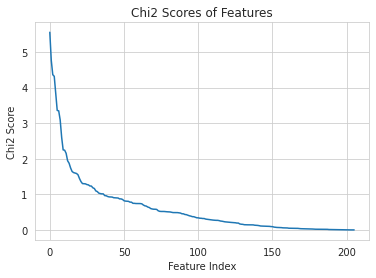

# Classe 'Ferramentas' :

 » Unigramas mais correlacionados:
. tool
. vis
. config
. test
. man

 » Bigramas mais correlacionados:
. op sourc
. javascrib framework
. virt machin

 » Principais correlações:
. tool
. vis
. config
. test
. man
. monit
. task
. integr
. comput
. project
. autom
. suit
. sourc
. control
. io
. program
. dynam
. php
. react
. langu
----------------------------------------------------------------------------------------------------------------------------



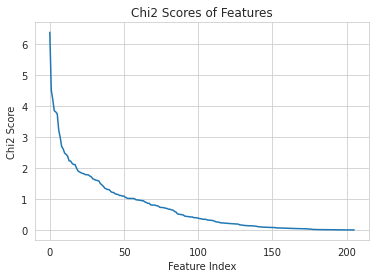

# Classe 'Linguagens e Frameworks' :

 » Unigramas mais correlacionados:
. langu
. dynam
. typ
. react
. program

 » Bigramas mais correlacionados:
. program langu
. op sourc
. javascrib framework

 » Principais correlações:
. langu
. dynam
. typ
. react
. program langu
. program
. funct
. javascrib
. serv
. view
. sourc
. html
. feat
. without
. clod
. cli
. op sourc
. object
. ad
. lik
----------------------------------------------------------------------------------------------------------------------------



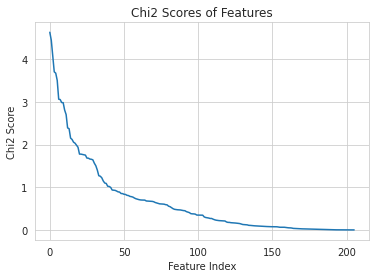

# Classe 'Plataformas' :

 » Unigramas mais correlacionados:
. cloud
. comput
. avail
. databas
. window

 » Bigramas mais correlacionados:
. platform serv
. sourc project
. test framework

 » Principais correlações:
. cloud
. comput
. platform serv
. avail
. databas
. window
. mobl
. engin
. host
. protocol
. libr
. hadoop
. query
. platform
. set
. test
. linux
. cor
. connect
. stor
----------------------------------------------------------------------------------------------------------------------------



In [ ]:
def get_feature_names(preProcessor,category_id:int):
    features_chi2 = chi2(preProcessor.features_train, preProcessor.labels_train == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(preProcessor.tfidf.get_feature_names_out())[indices]

    sorted_indices = np.argsort(features_chi2[0])[::-1]

    # Sort the chi2 scores
    sorted_chi2 = features_chi2[0][sorted_indices]

    # Create the line plot
    plt.plot(sorted_chi2)
    plt.xlabel('Feature Index')
    plt.ylabel('Chi2 Score')
    plt.title('Chi2 Scores of Features')
    plt.show()
    return feature_names

def print_important_feature(product):

    
    unigrams = [word for word in feature_names if len(word.split(' ')) == 1]
    bigrams = [word for word in feature_names if len(word.split(' ')) == 2]
    
    print("# Classe '{}' :".format(product))
    print("")
    print(" » Unigramas mais correlacionados:\n. {}".format('\n. '.join(unigrams[-5:][::-1])))
    print("")
    print(" » Bigramas mais correlacionados:\n. {}".format('\n. '.join(bigrams[-3:][::-1])))
    print("")
    print(" » Principais correlações:\n. {}".format('\n. '.join(feature_names[-20:][::-1])))
    print("----------------------------------------------------------------------------------------------------------------------------")
    print("")

for product, category_id in sorted(category_codes.items()):

    feature_names = get_feature_names(preProcessor, category_id)

    print_important_feature(product)



A decisão de correlacionar os labels dados ('Ferramentas', 'Linguagens e Frameworks' e 'Plataformas') com os códigos do dataset baseado na análise de uma amostra dos registros do dataset (Linhas 15, 27 e 46) provou-se acertada na medida em que os unigramas e bigramas mais relevantes à cada classe tem bastante identificação com seus temas.

*   Ferramentas = 'tool' / 'configuration 
*   Linguagens e Frameworks = 'language' / 'type'
*   Plataformas = 'cloud' / 'platform service'



# Seleção de Atributos


Definiremos o k inicialmente como 100 para visualizar a efetividade do código e, posteriormente, modificá-lo se necessário.

In [ ]:
selector = SelectKBest(chi2, k=100)
features_train = selector.fit_transform(preProcessor.features_train, preProcessor.labels_train)
features_test = selector.transform(preProcessor.features_test)

print(features_train.shape)
print(features_test.shape)

(237, 100)
(27, 100)


Foi testado para todos os modelos k= 50,100,85,90,125, os melhores resultados estavam entre 85 e 100, sem diferenças relevantes.

# Criação do Modelo

In [ ]:

def display_results(preProcessor,rfc_pred):
    acc = accuracy_score(preProcessor.labels_test, rfc_pred)
    f1 = f1_score(preProcessor.labels_test, rfc_pred, average='macro')
    print(classification_report(preProcessor.labels_test,rfc_pred))

    aux_df = preProcessor.labels_train.drop_duplicates().sort_values()
    conf_matrix = confusion_matrix(preProcessor.labels_test, rfc_pred)
    plt.figure(figsize=(12.8,6))
    sns.heatmap(conf_matrix, 
                annot=True,
                xticklabels=aux_df.values, 
                yticklabels=aux_df.values,
                cmap="Blues")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion matrix')
    plt.show()
    return f1,acc

In [ ]:
score_metrics = {'F1': 'f1_macro', 'Accuracy': make_scorer(accuracy_score)}


## 1. Random Forest

#### Cross Validation do Random Search

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 5)]

max_features = ['auto', 'sqrt']

max_depth = [int(x) for x in np.linspace(2, 10, num = 5)]
max_depth.append(None)

min_samples_split = [2, 5, 10]

min_samples_leaf = [4]

bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rfc = RandomForestClassifier(random_state=8)

random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=random_grid,
                                   n_iter=10, # número de combinações 
                                   scoring=score_metrics, # metodo de avaliação
                                   refit='F1', # método utilizado para refitagem
                                   cv=10, # número de folds
                                   verbose=1, 
                                   random_state=8, 
                                   n_jobs =-1) # processamento paralelo

random_search.fit(features_train, preProcessor.labels_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=8),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 4, 6, 8, 10, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [20, 65, 110, 155,
                                                         200]},
                   random_state=8, refit='F1',
                   scoring={'Accuracy': make_scorer(accuracy_score),
                            'F1': 'f1_macro'},
                   verbose=1)

In [ ]:
print("Os melhores hiperparâmetros encontrados com o Random Search são:")
print(random_search.best_params_)
print("")
print("A macro F1 obtida com esses hiperparâmetros é:")
print(random_search.best_score_)

Os melhores hiperparâmetros encontrados com o Random Search são:
{'n_estimators': 65, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 6, 'bootstrap': True}

A macro F1 obtida com esses hiperparâmetros é:
0.597365319927576


#### 1.2. Treinamento e avaliação do modelo

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         9
           1       0.86      0.46      0.60        13
           2       0.36      0.80      0.50         5

    accuracy                           0.59        27
   macro avg       0.63      0.64      0.59        27
weighted avg       0.70      0.59      0.60        27



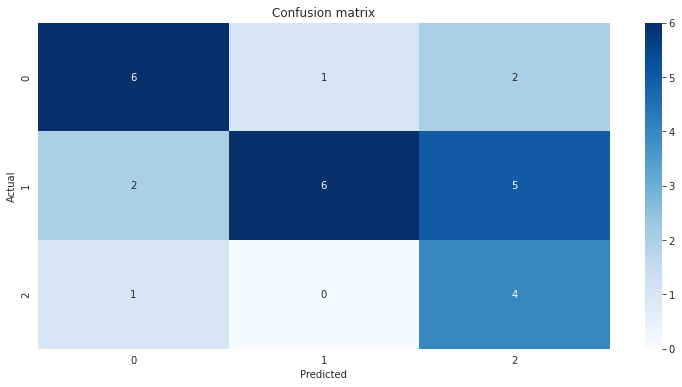

In [ ]:
results = random_search.cv_results_
best_rfc = random_search.best_estimator_ 
best_scorer_index = np.nonzero(results['rank_test_F1'] == 1)[0][0]
best_scorer_index

best_rfc.fit(features_train, preProcessor.labels_train)
rfc_pred = best_rfc.predict(features_test)


f1,acc = display_results(preProcessor,rfc_pred)

Dada Matriz de confusão, podemos notar alguns pontos referentes à cada classe:

Classe 0 - obteve uma boa performace

Classe 1,2 - houve bastante confusão na hora de diferenciar classes 1 e 2 para o modelo, porém para estimar a classe 1 obtiveram-se bons resultados.


In [ ]:
print(train_target.value_counts(),'\n', test_target.value_counts())

2    83
0    79
1    75
Name: classe, dtype: int64 
 1    13
0     9
2     5
Name: classe, dtype: int64


- Verificamos que há um pequeno desbalanceamento na base de treino, que inicialmente possuiu mais exemplos da classe 2 e menos exemplos da classe 1. Isso pode justificar a dificuldade do modelo em primeira instancia em diferenciar 1 de 2

In [ ]:
df_estimators_scores = pd.DataFrame(columns=['Estimator', 'Cross-validation Scores', 'Test Set Scores'])
d = {
     'Estimator': 'Random Forest',
     'Cross-validation Scores': (round(results['mean_test_F1'][best_scorer_index],3), round(results['mean_test_Accuracy'][best_scorer_index],3)),
     'Test Set Scores': (round(f1,3), round(acc,3))
}

df_estimators_scores = df_estimators_scores.append(d, ignore_index=True)
df_estimators_scores

,Estimator,Cross-validation Scores,Test Set Scores
0,Random Forest,"(0.597, 0.62)","(0.589, 0.593)"


#### Cross Validation do Grid Search

Como GRID SEARCH realiza todas as combinações lineares dos parâmetro, em aplicações que realmente desejamos variar os parâmetros ela não se faz muito útil (muito tempo de processamento), já que o número de modelos criados é igual à combinação linear de todas as possibilidades. Apenas realizado para fins de demonstração.

In [ ]:
bootstrap = [False]
max_depth = [30, 40, 50]
max_features = ['sqrt']
min_samples_leaf = [4]
min_samples_split = [5, 10, 15]
n_estimators = [20]

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

# Create a base model
rfc = RandomForestClassifier(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 10, test_size = None, random_state = 8)
# testando com fold 10 e test 0 pois ja temos um teste separado

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rfc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=2, n_jobs =-1)

# Fit the grid search to the data
grid_search.fit(features_train, preProcessor.labels_train)

print("Os melhores hiperparâmetros encontrados com o Random Search são:")
print(grid_search.best_params_)
print("")
print("A acurácia média obtida com esses hiperparâmetros é:")
print(grid_search.best_score_)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
Os melhores hiperparâmetros encontrados com o Random Search são:
{'bootstrap': False, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 20}

A acurácia média obtida com esses hiperparâmetros é:
0.6083333333333333


## 2. SVM

In [ ]:

C = [.0001, .001, .01]


gamma = [.0001, .001, .01, .1, 1, 10, 100]


degree = [1, 2, 3, 4, 5]


kernel = ['linear', 'rbf', 'poly']


probability = [True]


random_grid = {'C': C,
              'kernel': kernel,
              'gamma': gamma,
              'degree': degree,
              'probability': probability
             }

svc = svm.SVC(random_state=8)


random_search = RandomizedSearchCV(estimator=svc,
                                   param_distributions=random_grid,
                                   n_iter=10,
                                   scoring=score_metrics,
                                   refit='F1',
                                   cv=10, 
                                   verbose=1, 
                                   random_state=8,
                                   n_jobs =-1)


random_search.fit(features_train, preProcessor.labels_train)

print("Os melhores hiperparâmetros encontrados com o Radom Search são:")
print(random_search.best_params_)
print("")
print("A macro F1 obtida com esses hiperparâmetros é:")
print(random_search.best_score_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Os melhores hiperparâmetros encontrados com o Radom Search são:
{'probability': True, 'kernel': 'poly', 'gamma': 10, 'degree': 4, 'C': 0.01}

A macro F1 obtida com esses hiperparâmetros é:
0.5397300091387451


              precision    recall  f1-score   support

           0       0.83      0.56      0.67         9
           1       0.82      0.69      0.75        13
           2       0.50      1.00      0.67         5

    accuracy                           0.70        27
   macro avg       0.72      0.75      0.69        27
weighted avg       0.76      0.70      0.71        27



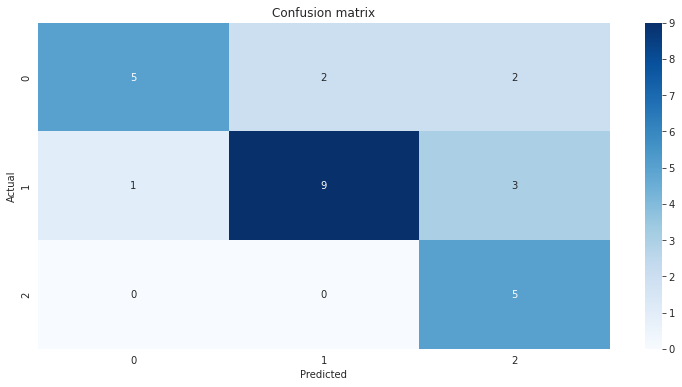

In [ ]:
results = random_search.cv_results_

best_svm = random_search.best_estimator_ 

best_scorer_index = np.nonzero(results['rank_test_F1'] == 1)[0][0]
best_svm.fit(features_train, preProcessor.labels_train)
svm_pred = best_svm.predict(features_test)

f1,acc = display_results(preProcessor,svm_pred)

É notório que o modelo de SVM não performou bem, obtendo um bom resultado na classe 0 porém obtendo erros entre a classe 1 e 2, semelhante ao que observamos com o Random Forest. A classe 0 possui uma acurácia melhor utilizando este modelo. 

Visto que a classe 0 é a mais distinta em mais de um modelo, ratifica que a ideia de que há uma maior dificuldade entre as classes 1 e 2.


In [ ]:
d = {
     'Estimator': 'SVM',
     'Cross-validation Scores': (round(results['mean_test_F1'][best_scorer_index],3), round(results['mean_test_Accuracy'][best_scorer_index],3)),
     'Test Set Scores': (round(f1,3), round(acc,3))
}

df_estimators_scores = df_estimators_scores.append(d, ignore_index=True)

df_estimators_scores

,Estimator,Cross-validation Scores,Test Set Scores
0,Random Forest,"(0.597, 0.62)","(0.589, 0.593)"
1,SVM,"(0.54, 0.556)","(0.694, 0.704)"


## 3. Multinomial Naïve Bayes


              precision    recall  f1-score   support

           0       0.78      0.78      0.78         9
           1       0.89      0.62      0.73        13
           2       0.56      1.00      0.71         5

    accuracy                           0.74        27
   macro avg       0.74      0.80      0.74        27
weighted avg       0.79      0.74      0.74        27



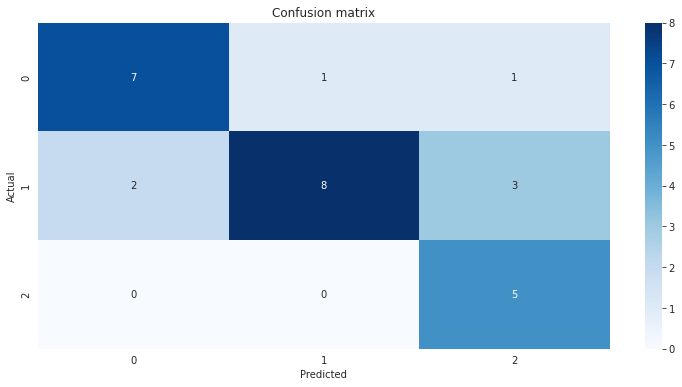

In [ ]:
mnbc = MultinomialNB(alpha=0.433,force_alpha=False,fit_prior=True)
mnbc.fit(features_train, preProcessor.labels_train)
mnbc_pred = mnbc.predict(features_test)
f1,acc = display_results(preProcessor, mnbc_pred)



Fizemos a tunagem de parâmetro de 0.0, 0.5, 0.1, obtendo bons resultados entre 0.0 e 0.433. 

Semelhante aos demais modelos, podemos observar uma tendência de erro entre as a classificação da classe 1 como 2. 

In [ ]:


scores = cross_validate(mnbc, features_train, preProcessor.labels_train, scoring=score_metrics, cv=10, return_train_score=True)
print(scores.keys())
print(scores['test_F1'])

dict_keys(['fit_time', 'score_time', 'test_F1', 'train_F1', 'test_Accuracy', 'train_Accuracy'])
[0.83839406 0.81388889 0.79047619 0.6521164  0.82633053 0.77593431
 0.77593431 0.65555556 0.75       0.61598441]


Podemos notar que o Cross validation teve valores bem divergentes entre os folds, indicando que possuímos Folds mais reprentativos e outros menos representativos.

In [ ]:
print("Cross-validation scores")
print("F1: %.3f - Accuracy: %.3f " % (round(np.mean(scores['test_F1']),3), round(np.mean(scores['test_Accuracy']),3)))
print('---------------------------')
print("Test scores")
print("F1: %.3f - Accuracy: %.3f " % (f1, acc))

Cross-validation scores
F1: 0.749 - Accuracy: 0.759 
---------------------------
Test scores
F1: 0.740 - Accuracy: 0.741 


In [ ]:
d = {
     'Estimator': 'MultinomialNB',
     'Cross-validation Scores': (round(np.mean(scores['test_F1']),3), round(np.mean(scores['test_Accuracy']),3)),
     'Test Set Scores': (round(f1,3), round(acc,3))
}

df_estimators_scores = df_estimators_scores.append(d, ignore_index=True)
df_estimators_scores

,Estimator,Cross-validation Scores,Test Set Scores
0,Random Forest,"(0.597, 0.62)","(0.589, 0.593)"
1,SVM,"(0.54, 0.556)","(0.694, 0.704)"
2,MultinomialNB,"(0.749, 0.759)","(0.74, 0.741)"


# Análise do modelo


Vamos escolher o modelo gerado com o algoritmo Naive Bayes por ter alcançado os melhores indicadores.

In [ ]:
predictions = mnbc.predict(features_test)

In [ ]:
# Indexes of the test set
index_X_test = test_df.index

# We get them from the original df
df_test = df.loc[index_X_test]

# Add the predictions

df_test['Prediction'] = predictions

# Clean columns
df_test = df_test[['parsed', 'classe', 'Prediction']]

# Decode
df_test['classe_Predicted'] = df_test['Prediction']

# Clean columns again
df_test = df_test[['parsed', 'classe', 'classe_Predicted']]

In [ ]:
condition = (df_test['classe'] != df_test['classe_Predicted'])

df_misclassified = df_test[condition]

df_misclassified

,parsed,classe,classe_Predicted
95,oau op auth spec cli apply access protect reso...,1,0
12,nashorn op sourc jvm bas javascrib engin repla...,0,1
260,jruby op sourc jav impl ruby program langu rub...,1,0
78,graphql dat query langu describ complex nest d...,0,2
4,kubernet op sourc impl contain clust man,1,2
242,neventst ak jol eventst disambigu geteventst c...,1,2
181,tensorflow op sourc libr machin learn machin i...,1,2


In [ ]:
df_misclassified.classe_Predicted.value_counts()

2    4
0    2
1    1
Name: classe_Predicted, dtype: int64

Conforme haviamos analisado anteriormente, vemos que o modelo possui uma alta taxa de erro quando tenta classificar a classe 1. Nestes casos, ela é considerada como a classe 2. 

A fim de tentar resolver esse problema iremos tentar rebalancear a base de treino.

Dentre as linhas que não foram identificadas, podemos destacar a linha 95, OAuth, que foi classificada como Plataforma, porém, à vista dos analistas, poderia ser considerada uma ferramenta. 

Da mesma forma, na linha 181, Tensor Flow poderia ser classificado como uma ferramenta, já que é uma biblioteca dentro de uma linguagem. 


1. Foi notado dentre as palavras identificadas que SOURC e suas variáveis são a maior parte da confusão entre o grupo 1 e 2. Iremos adicionar esse stemm no stop_words.

Resultado:

Não houve qualquer melhora ou piora. Os resultados do conjunto de teste foi idêntico.


2. Outra tentativa que tentaremos realizar será a de diminuir ainda mais o min_df e aumentar o max_df do tfidf a fim de verificar se a análise identifica os nomes das plataformas como palavras chave.


Resultado:

Obtivemos um resultado bem pior que o anterior, mostrando que o modelo não conseguiu generalizar as classes.

|Estimator|	Cross-validation| Scores|	Test Set Scores|
|----|----|----|---|
0|	Random Forest|	(0.173, 0.35)|	(0.104, 0.185)|
1|	SVM	|(0.173, 0.35)|	(0.104, 0.185)|
2|	MultinomialNB	|(0.173, 0.35)|	(0.537, 0.556)|

3. Foi realizado a tentativa de aumentar min_df e diminuir max_df a fim de verificar a alteração na performance.

Resultado:


original 


|	Estimator	|Cross-validation| Scores|	Test Set Scores|
|-----|----|----|----|
0|	Random Forest	|(0.597, 0.62)|	(0.589, 0.593)
1|	SVM	|(0.54, 0.556)|	(0.694, 0.704)
2|	MultinomialNB	|(0.749, 0.759)|	(0.74, 0.741)


Foi notado uma melhora considerável utilizando min_df = 0.03 e max_df = 0.97.

|Estimator|	Cross-validation| Scores|	Test Set Scores|
|----|----|----|---|
0|	Random Forest|(0.605, 0.616)	|(0.606, 0.63)
1	|SVM	|(0.442, 0.484)	|(0.622, 0.63)
2	|MultinomialNB	|(0.659, 0.666)	|(0.78, 0.778)




min_df = 0.1 e max_df = 0.90.

|Estimator|	Cross-validation| Scores|	Test Set Scores|
|----|----|----|---|
0|	Random Forest|	(0.545, 0.565)	|(0.533, 0.556)
1	|SVM	|(0.418, 0.439)	|(0.408, 0.407)
2	|MultinomialNB	|(0.515, 0.532)	|(0.542, 0.556)

min_df = 0.05 e max_df = 0.95.

|Estimator|	Cross-validation| Scores|	Test Set Scores|
|----|----|----|---|
0|	Random Forest|	(0.575, 0.586)	|(0.663, 0.667)
1|	SVM|	(0.392, 0.486)|	(0.433, 0.444)
2|	MultinomialNB	|(0.626, 0.628)	|(0.731, 0.741)

min_df = 0.04 e max_df = 0.96.

|Estimator|	Cross-validation| Scores|	Test Set Scores|
|----|----|----|---|
0|	Random Forest|	(0.568, 0.582)|	(0.649, 0.667)
1	|SVM	|(0.391, 0.489)	|(0.353, 0.37)
2	|MultinomialNB|	(0.638, 0.641)|	(0.731, 0.741)



Após essas análises, conluímos que o melhor resultado foi com  min_df = 0.03 e max_df = 0.97.

4. Foi analisado se a distribuição desbalanceada entre as classes 1 e 2 para o conjunto de treino tem algum impacto na performance. Para isso utilizamos um conjunto (random_state=2) que possui apenas 2 dados a mais para a classe 2.

Resultado:

O modelo foi capaz de identificar as linhas da classe 1 que estavam sendo mal classificadas, porém obteve um resultado final pior, pois cometeu erros de classificação na classe 2. Isso nos leva a acreditar que um treinamento com todos os dados presentes pode gerar bons resultados finais.

|Estimator|Cross-validation Scores|Test Set Scores
|----|-----|----|
0|Random Forest|(0.607, 0.616)|(0.608, 0.63)
1|SVM|(0.392, 0.447)|(0.457, 0.519)
2|MultinomialNB|(0.661, 0.662)|(0.777, 0.778)